In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 8, 6
from sklearn.linear_model import LinearRegression
import scipy.stats as stats

## Load Data

In [41]:
def load_and_prepare_data(file_path):
    # Load data
    data = pd.read_excel(file_path)
    
    # Assuming the first column is 'Year' and subsequent columns are countries
    data.columns = ['Year'] + [f'Country{i+1}' for i in range(data.shape[1] - 1)]
    return data

## Perform Linear Regressions for each country in a cluster 

In [42]:
def perform_regression(data, cluster, display):
    # Initialize the regression model
    model = LinearRegression()

    # Setup the plot
    plt.figure(figsize=(14, 8))
    
    # Colors for the plots
    colors = plt.cm.viridis(np.linspace(0, 1, data.shape[1] - 1))
    
    # Variable for sum of all slopes
    sum_of_slopes = 0
    slopes = []

    # Perform regression for each country
    for i, column in enumerate(data.columns[1:]):  # Skip 'Year' column
        
        
        x = []
        y = []
        for year, eci in zip(data['Year'], data[column]):
            if pd.notnull(year) and pd.notnull(eci):
                x.append(year)
                y.append(eci)
        x = np.array(x).reshape(-1, 1)  # Years
        y = np.array(y)  # ECI values
        

        
        # Fit model
        model.fit(x, y)
        
        # Predict values for a smooth line
        y_pred = model.predict(x)
        # Add slope to sum
        sum_of_slopes += model.coef_[0]
        slopes.append(model.coef_[0])
        
        # Scatter plot of actual data
        plt.scatter(x, y, color=colors[i], label=f'{column} (slope: {model.coef_[0]:.2f})')
        
        # Line plot of the regression line
        plt.plot(x, y_pred, color=colors[i], linestyle='--')
        
    # Adding the average slope to the plot
    avg_slope = sum_of_slopes / (data.shape[1] - 1)
    plt.axhline(y=avg_slope, color='r', linestyle='-', label=f'Average Slope: {avg_slope:.2f}')

    if display:
        # Adding plot legends and labels
        plt.legend(title="Country Index (Growth Rate)")
        plt.title(f'{cluster} Regression Analysis')
        plt.xlabel('Year')
        plt.ylabel('Economic Complexity Index (ECI)')
        plt.grid(True)

        # Show plot
        plt.show()
    else:
        plt.close()
    
    return slopes

## Perform the regressions for each cluster. 
- each cluster was determined by Open Data Barometer's determination of countries' government data transparency
- store slopes to run a t-test on the two most different clusters (high capacity - most transparent with their data, low capacity - least transparent with their data)
- graph the regressions for the two clusters I am testing

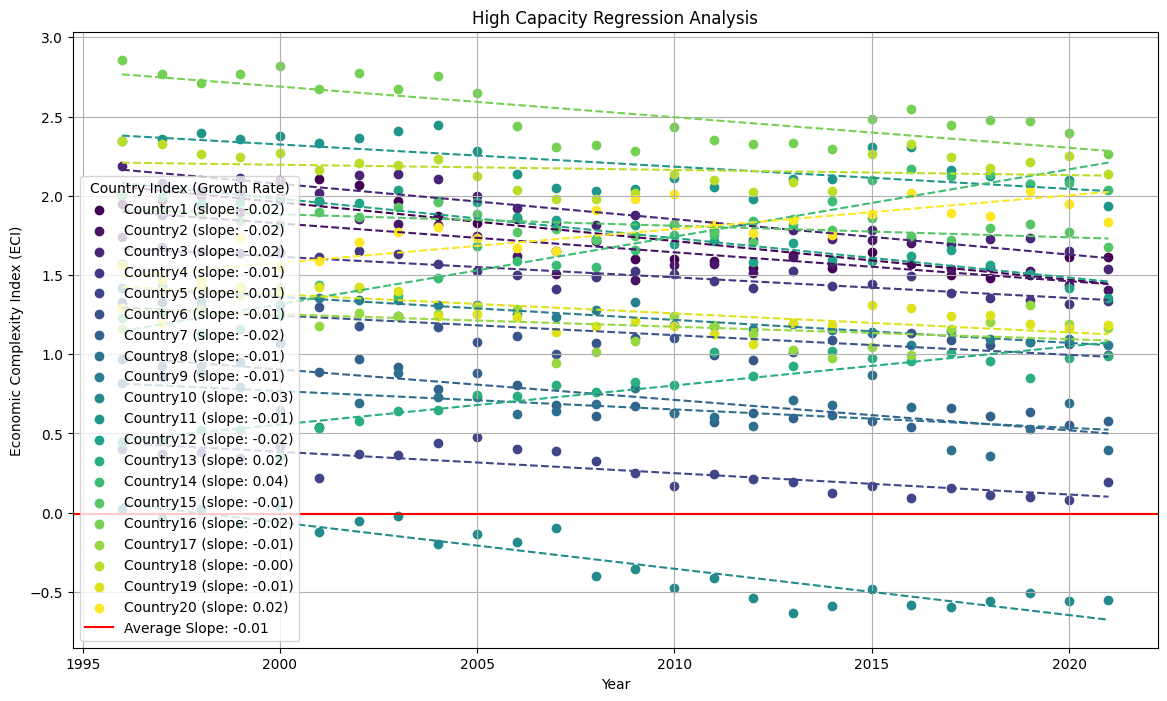

In [43]:
# Path to the Excel file
file_path = 'Processed_Data_Clusters/High_Capacity.xlsx'  # Update this path
cluster_name = file_path[24:-5].replace('_', ' ')
# Load data
data = load_and_prepare_data(file_path)
# Perform regression analysis and plotting
slopes_high_capacity = perform_regression(data, cluster_name, True)


In [44]:
# Path to the Excel file
file_path = 'Processed_Data_Clusters/Emerging_and_Advancing.xlsx'  # Update this path
cluster_name = file_path[24:-5].replace('_', ' ')
# Load data
data = load_and_prepare_data(file_path)
# Perform regression analysis and plotting
slopes_emerging = perform_regression(data, cluster_name, False) # Do not display the plot

In [45]:
# Path to the Excel file
file_path = 'Processed_Data_Clusters/Capacity_Constrained.xlsx'  # Update this path
cluster_name = file_path[24:-5].replace('_', ' ')
# Load data
data = load_and_prepare_data(file_path)
# Perform regression analysis and plotting
slopes_constrained = perform_regression(data, cluster_name, False) # Do not display the plot

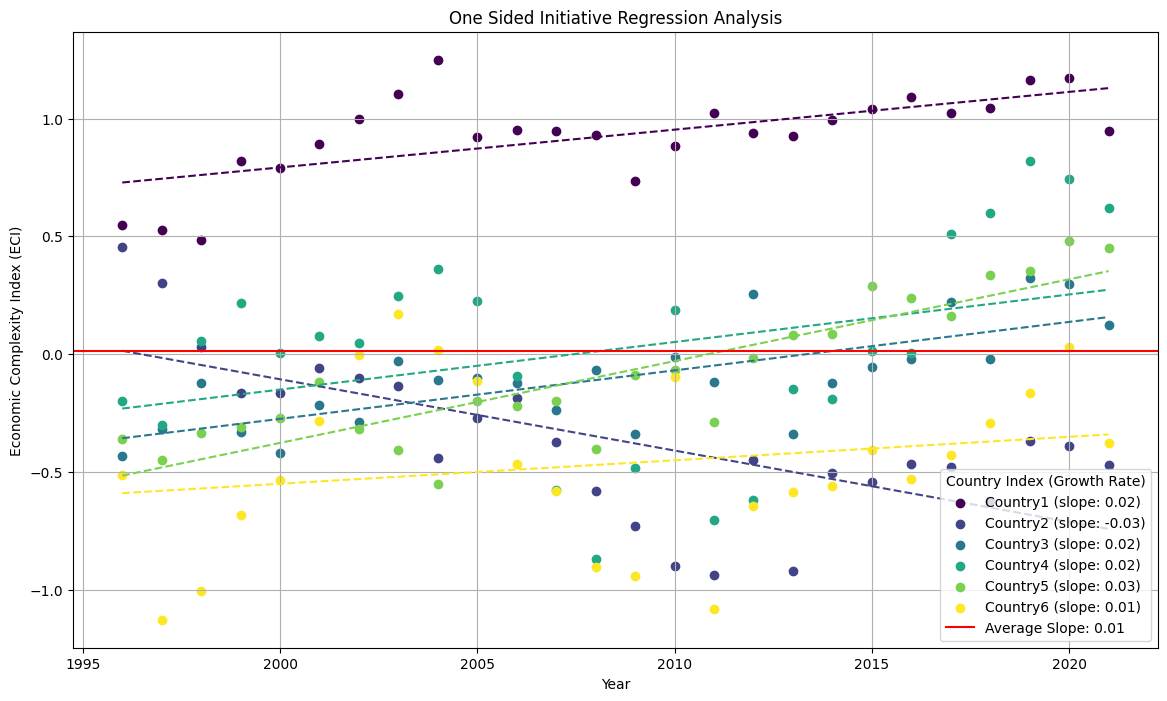

In [46]:
# Path to the Excel file
file_path = 'Processed_Data_Clusters/One_Sided_Initiative.xlsx'  # Update this path
cluster_name = file_path[24:-5].replace('_', ' ')
# Load data
data = load_and_prepare_data(file_path)
# Perform regression analysis and plotting
slopes_one_sided = perform_regression(data, cluster_name, True)

## Check t-test statistics conditions for both samples

In [47]:
# Normality test for both groups
normality_high_capacity = stats.shapiro(slopes_high_capacity)
normality_one_sided = stats.shapiro(slopes_one_sided)

print(f"Normality test for High Capacity cluster: Statistic={normality_high_capacity.statistic}, P-value={normality_high_capacity.pvalue}")
print(f"Normality test for One Sided Initiative cluster: Statistic={normality_one_sided.statistic}, P-value={normality_one_sided.pvalue}")


Normality test for High Capacity cluster: Statistic=0.7870138883590698, P-value=0.0005566879990510643
Normality test for One Sided Initiative cluster: Statistic=0.8268217444419861, P-value=0.10100556910037994


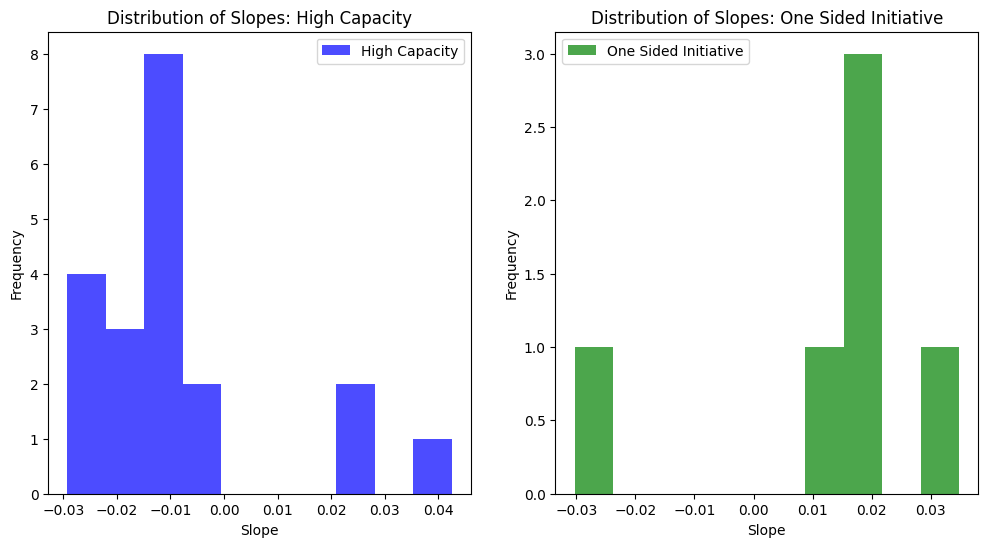

In [48]:
# Histograms for slope distributions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(slopes_high_capacity, bins=10, color='blue', alpha=0.7, label='High Capacity')
plt.title('Distribution of Slopes: High Capacity')
plt.xlabel('Slope')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(slopes_one_sided, bins=10, color='green', alpha=0.7, label='One Sided Initiative')
plt.title('Distribution of Slopes: One Sided Initiative')
plt.xlabel('Slope')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Run t-test!

In [49]:
# Two-sample t-test
# Check for equal variances
levene_test = stats.levene(slopes_high_capacity, slopes_one_sided)
print(f"Levene test for equal variances: Statistic={levene_test.statistic}, P-value={levene_test.pvalue}")

# T-test
t_test_result = stats.ttest_ind(slopes_high_capacity, slopes_one_sided, equal_var=(levene_test.pvalue > 0.05))
print(f"Two-sample t-test result: Statistic={t_test_result.statistic}, P-value={t_test_result.pvalue}")

Levene test for equal variances: Statistic=0.09691676765971104, P-value=0.758249571227911
Two-sample t-test result: Statistic=-2.3468227545046925, P-value=0.02752117636260821
